# Summary

1. [Solve Dependencies](#solve-dependencies)
2. [Create Labels CSV File](#create-labels-csv-file)
3. [Data Split](#data-split)
4. [SimCLR](#simclr)


# Solve Dependencies
<a id="solve-dependencies"></a>


In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import typing as tp
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Create CSV File to Store Filenames and Labels
<a id="create-labels-csv-file"></a>


In [2]:
def create_label_csv(root_dir, output_csv):
    # Initialize an empty list to hold the data
    data = []

    # Define class names and their corresponding labels
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        
        # Check if the class folder exists
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist.")
            continue
        
        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats if needed
                # Create a tuple of (filename, label)
                data.append((class_name+'/'+filename, class_name))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['filename', 'label'])
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"CSV file created at: {output_csv}")

In [3]:
# Specify the directory and the output CSV file name
root_directory = 'data/train'  # Path to the train directory
output_csv_file = 'data/train.csv'  # Output CSV file name

create_label_csv(root_directory, output_csv_file)


CSV file created at: data/train.csv


# Data Split
<a id="data-split"></a>


### Dataset Class

In [4]:
class OCTDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        self.images_dir = images_dir
        self.labels_csv = labels_csv
        self.transform = transform
        
        # Carrega o arquivo CSV e filtra pelos índices, se fornecidos
        labels_df = pd.read_csv(labels_csv)
        
        if indices is not None:
            # Seleciona apenas os índices fornecidos
            labels_df = labels_df.iloc[indices].reset_index(drop=True)
        
        # Armazena os caminhos das imagens e rótulos como listas
        self.image_paths = [os.path.join(images_dir, fname) for fname in labels_df['filename']]
        self.labels = labels_df['label'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carrega a imagem a partir do caminho
        image = Image.open(self.image_paths[idx]).convert("RGB")
        
        # Aplica as transformações, se existirem
        if self.transform:
            image = self.transform(image)
        
        # Retorna a imagem e o rótulo
        label = self.labels[idx]
        return image, label

### Split Function

In [5]:
def create_split_datasets(dataset, split_ratio=0.8, seed=42):
    # Divide o dataset em duas partes principais
    bigger_part_indices, smaller_part_indices = train_test_split(
        range(len(dataset)),
        test_size=(1 - split_ratio),
        stratify=dataset.labels,
        random_state=seed
    )

    # Divide a parte maior em treino e validação
    bigger_train_indices, bigger_val_indices = train_test_split(
        bigger_part_indices,
        test_size=0.4,
        stratify=np.array(dataset.labels)[bigger_part_indices],
        random_state=seed
    )

    # Divide a parte menor em treino e validação
    smaller_train_indices, smaller_val_indices = train_test_split(
        smaller_part_indices,
        test_size=0.2,
        stratify=np.array(dataset.labels)[smaller_part_indices],
        random_state=seed
    )

    # Cria os datasets de treino e validação
    bigger_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_train_indices,
        transform=dataset.transform
    )

    bigger_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=bigger_val_indices,
        transform=dataset.transform
    )

    # Criar os datasets de treino e validação
    smaller_train_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_train_indices,
        transform=dataset.transform
    )

    smaller_val_dataset = OCTDataset(
        images_dir=dataset.images_dir,
        labels_csv=dataset.labels_csv,
        indices=smaller_val_indices,
        transform=dataset.transform
    )
    
    return bigger_train_dataset, bigger_val_dataset, smaller_train_dataset, smaller_val_dataset


### Split

In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for SqueezeNet
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Instantiate the dataset
root_dir = 'data/train'  # Replace with the actual path to your dataset root
dataset = OCTDataset(
    images_dir=root_dir,
    labels_csv='data/train.csv',
    transform=transform
)

# Dividir o conjunto de treino em auto-supervisão e downstream
self_supervised_train, self_supervised_val, supervised_train, supervised_val = create_split_datasets(
    dataset, split_ratio=0.8, seed=42)

In [7]:
# Check the size training dataset
print("Train:", len(dataset))

# Check the size of each dataset
print("Self-Supervised Train:", len(self_supervised_train))
print("Self-Supervised Validation:", len(self_supervised_val))
print("Downstream Train:", len(supervised_train))
print("Downstream Validation:", len(supervised_val))

Train: 108309
Self-Supervised Train: 51988
Self-Supervised Validation: 34659
Downstream Train: 17329
Downstream Validation: 4333


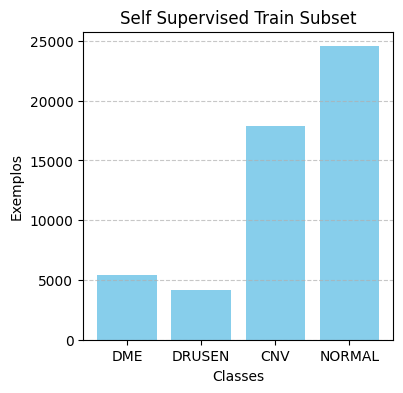

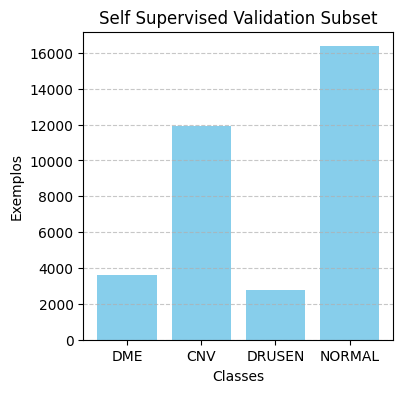

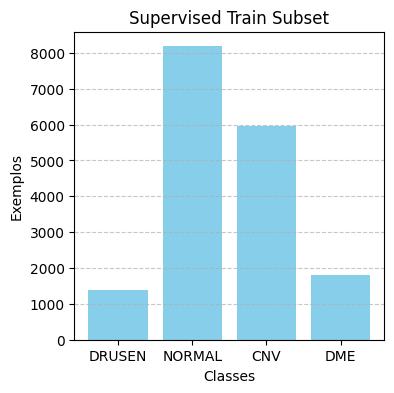

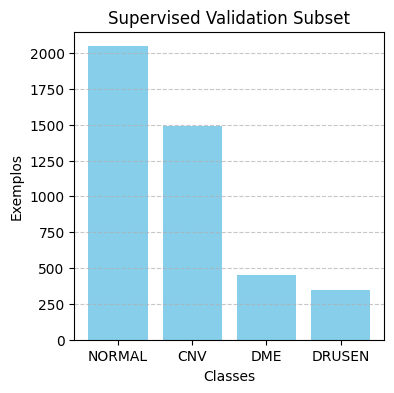

In [8]:
def plot_class_distribution(dataset, dataset_name):
    labels = np.array(dataset.labels)  # Obtém os rótulos do dataset
    
    class_counts = Counter(labels)  # Conta os exemplos por classe

    # Tamanho do gráfico
    plt.figure(figsize=(4, 4))  # Ajusta o tamanho do gráfico (largura, altura)
    
    # Gráfico de barras
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Exemplos")
    plt.title(f"{dataset_name}")

    # Mostra a grade para melhor visualização
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

# Plotar distribuições para cada conjunto
plot_class_distribution(self_supervised_train, "Self Supervised Train Subset")
plot_class_distribution(self_supervised_val, "Self Supervised Validation Subset")
plot_class_distribution(supervised_train, "Supervised Train Subset")
plot_class_distribution(supervised_val, "Supervised Validation Subset")

# SimCLR
<a id="simclr"></a>

### Set Checkpoint Path Device, and Number of Workers

In [15]:
# Global seed (useful for reproducibility of our pipeline).
#
# pl.seed_everything(42)

# Path to the folder where the pretrained models are saved.
#
CHECKPOINT_PATH = "saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility.
#
torch.backends.cudnn.deterministic = True

# Ensure that it will use the most suitable (fastest) algoritms for this hardware.
#
torch.backends.cudnn.benchmark = False

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores.
#
import os
NUM_WORKERS = os.cpu_count()

# It will use GPUs whenever they are available.
#
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 8


### Load Pretrained Models

In [16]:
import urllib.request
from urllib.error import HTTPError

# Github URL from where we will import pre-trained models.
#
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"

# Files to download
#
# pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
#                     "tensorboards/SimCLR/events.out.tfevents.SimCLR",
#                     "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files = []

# One file per logistic regression size.
#
# pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]

# Create checkpoint path if it doesn't exist yet.
#
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
#
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Error. Please download files from the Drive folder. Err:\n", e)

print("Download finished!")

Download finished!


### Define Augmentation Schema

In [17]:
# Class whose method "call" returns a list of k random augmentations of x.
# Five transformations are applied in each random augmentation.
#
class ContrastiveTransformations(object):
    
    def __init__(self, k=2):
        self.k = k

        self.base_transforms = transforms.Compose([

            #  1) Random horizontal flip:
            #
            transforms.RandomHorizontalFlip(),
            
            #  2) Crop-and-resize:
            #
            transforms.RandomResizedCrop(size=96),

            #  5) Gaussian blur:
            #
            transforms.GaussianBlur(kernel_size=9),
            
            # Converts the Numpy array into a Pytorch tensor of FloatTensor of shape (C x H x W)
            # in the range [0.0, 1.0].
            #
            transforms.ToTensor(),
            
            # Normalizes the tensors.
            #
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.k)]

print("Contrastive transformation method implemented.")

Contrastive transformation method implemented.


### Checkout Some Augmented Images on Our Dataset

<Figure size 640x480 with 0 Axes>

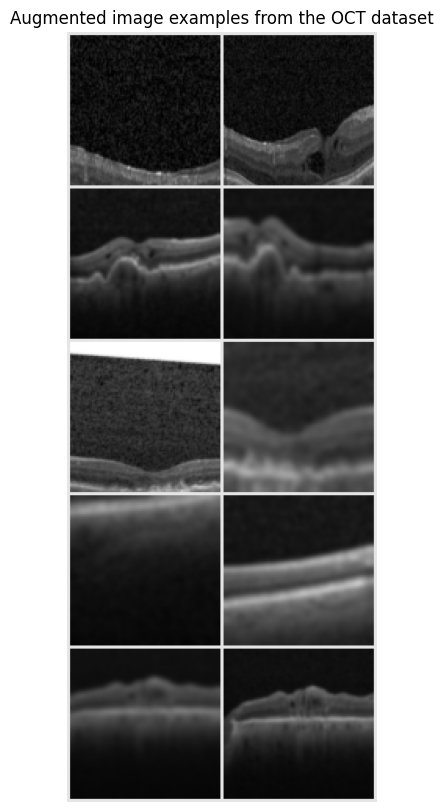

In [18]:
# Set contrastive transformations for the self-supervised training dataset.
self_supervised_train.transform = ContrastiveTransformations(k=2)

# Defina o número de imagens aumentadas que deseja visualizar
N = 5

# Extrair e empilhar N imagens aumentadas do dataset, aplicando as transformações
imgs = torch.stack([img for i in range(N) for img in self_supervised_train[i][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

# Exibir o grid com matplotlib
plt.set_cmap('cividis')
plt.figure(figsize=(10, 10))
plt.title('Augmented image examples from the OCT dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Implement the SimCLR Model

Let's implement the SimCLR architecture. The loss function is given by:

\begin{align}
{\cal L}_{i,j} &=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}\\
&=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right],
\end{align}

where sim is the similarity function (in our case, the cosine similarity):

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}.
$$


In [19]:
import pytorch_lightning as pl

class SimCLR(pl.LightningModule):
    '''
    SimCLR model with a SqueezeNet backbone.

    Args:
        hidden_dim: The dimension of the hidden layer in the projection head. 
            Number of units in the hidden layer; we'll use 25% of the number of classes.
        lr: The learning rate for the optimizer.
        temperature: The temperature parameter for the contrastive loss.
        weight_decay: The weight decay for the optimizer.
        max_epochs: The maximum number of epochs for training.

    '''

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Representation extraction function h_\theta using SqueezeNet.
        self.convnet = torchvision.models.squeezenet1_1(weights=None)

        # Replace the classifier head of SqueezeNet.
        # We add an extra fully connected layer to form the projection head.
        self.convnet.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Ensures output size is 1x1 before the final layers.
            nn.Flatten(),             # Flattens the tensor for the linear layer.
            nn.Linear(512, 4 * hidden_dim),  # First fully connected layer with output 4 * hidden_dim.
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Second fully connected layer with output hidden_dim.
        )


    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''

        # Adam optimizer.
        #
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
        
        # Uses the cosine annealing schedule to set the learning rate (eta).
        #
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
        #
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
    
    
    def info_nce_loss(self, batch, mode='train'):
        '''
        This method defines the InfoNCE loss (SimCLR's paper loss) used in the pretext task learning.
        
        Computes the InfoNCE loss for the batch of images.

        Args:
            batch: The batch of images.
            mode: The mode of the model (train or val). [Log purposes]

        Returns:
            The InfoNCE loss for the batch of images.
        '''

        # _ is a special variable that stores the last value in batch.
        #

        imgs, _ = batch

        # Concat images in the zero dimension (rows).
        #
        # Verifique se o batch é uma lista ou tupla; caso sim, concatene os tensores
        if isinstance(imgs, (list, tuple)):
            imgs = torch.cat(imgs, dim=0)

        # Encode all images using the representation extraction function
        # 
        # i.e. pass each image through the same ResNet-18.
        #
        feats = self.convnet(imgs)

        # Calculate cosine similarity. Similarity is computed along the
        # last dimension of the tensor (that's what dim=-1 means, like in Python's lists)
        #
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)

        # Mask out cosine similarity to itself
        # (to avoid to compute similarity against itself):
        #
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        # // is the integer division operator in Python:
        #
        # (Sligthly different from the paper, where they are indices 2k-1 and 2k)
        #
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        # Computing the InfoNCE loss:
        #
        cos_sim = cos_sim / self.hparams.temperature        
        result = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        result = result.mean()

        # Logging loss (to visualize later using the TensorBoard):
        #
        self.log(mode+'_loss', result)

        # Getting ranking position of positive example (i.e., we see how far it is
        # when compared with the negative examples). Useful to compute top-k metrics.
        #
        comb_sim = torch.cat([cos_sim[pos_mask][:,None], 
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # Logging ranking metrics:
        #
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return result
    
    # Training step method.
    #
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    # Validation step method.
    #
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

print("SimCLR model sucessfully implemented.")

SimCLR model sucessfully implemented.


### Execute the Pretext Task Learning

In [20]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

def train_simclr(batch_size, max_epochs=500, **kwargs):
    """
    Function to train the SimCLR model.

    Args:   
        batch_size: The batch size.
        max_epochs: The maximum number of epochs.
        **kwargs: Additional arguments to pass to the model.
    
    Returns:
        The trained SimCLR model.
    """

    # Instantiation of a Pytorch Lightining Trainer object:
    #
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR-SqueezeNet'),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=False, 
                mode='max', 
                monitor='val_acc_top5', 
                filename='last'),
            LearningRateMonitor('epoch')])
    
    # Optional logging argument, it is not necessary.
    #
    trainer.logger._default_hp_metric = None 

    # Check whether pretrained model exists. If yes, load it and skip training.
    #
    # pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR-SqueezeNet.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')

        # Loads the model with the saved hyperparameters.
        #
        model = SimCLR.load_from_checkpoint(pretrained_filename) 
    
    # If there is no pretrained model, train it!
    #
    else:

        # Loading training data."pin_memory=True" is useful when training with GPU (CUDA),
        # because it stores the data into the pinned memory, rendering the process faster.
        # "drop_last=True" ignores the last minibatch of your epoch if is smaller than the
        # previous minibatches.
        #
        train_loader = DataLoader(
            self_supervised_train,
            batch_size=batch_size, 
            shuffle=True,
            drop_last=True, 
            pin_memory=True, 
            num_workers=NUM_WORKERS)
        
        # Loading validation data (for hyperparameter tuning). 
        #
        val_loader = DataLoader(
            self_supervised_val,
            batch_size=batch_size, 
            shuffle=False,
            drop_last=False, 
            pin_memory=True, 
            num_workers=NUM_WORKERS)

        # Train model.
        #
        model = SimCLR(max_epochs=max_epochs, **kwargs)

        # Checa se existe um checkpoint para retomar
        #
        checkpoint_version = CHECKPOINT_PATH + '/SimCLR-SqueezeNet/lightning_logs/version_4/checkpoints/last.ckpt'
        if os.path.isfile(checkpoint_version):
            print(f"Checkpoint encontrado em {checkpoint_version}, retomando o treinamento...")
            trainer.fit(model, train_loader, val_loader, ckpt_path=checkpoint_version)
        else:
            trainer.fit(model, train_loader, val_loader)

        # Get best checkpoint yielded by training.
        #
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model


# Let's train our SimCLR!
#
simclr_model = train_simclr(batch_size=16,
                            hidden_dim=1,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=1)

%load_ext tensorboard
%tensorboard --logdir saved-models/tensorboards/SimCLR-SqueezeNet/

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at saved_models/SimCLR-SqueezeNet/lightning_logs/version_4/checkpoints/last.ckpt
/home/juliana/Documentos/classification-oct-self-supervised-learning/.venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from 'saved_models/SimCLR-SqueezeNet/lightning_logs/version_4/checkpoints' to 'saved_models/SimCLR-SqueezeNet/lightning_logs/version_9/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | convnet | SqueezeNet | 724 K  | train
-----------------------------------------------
724 K     Trainable params
0         Non-trainable params
724 K     Total params
2.898     T

Checkpoint encontrado em saved_models/SimCLR-SqueezeNet/lightning_logs/version_4/checkpoints/last.ckpt, retomando o treinamento...


`Trainer.fit` stopped: `max_epochs=1` reached.


In [22]:
CHECKPOINT_PATH

'saved-models'